# Its that time of the year folks! This year "March Madness" 🏀 will take place from March 16 to April 3. Can the power of data science help us predict the Elite 8?

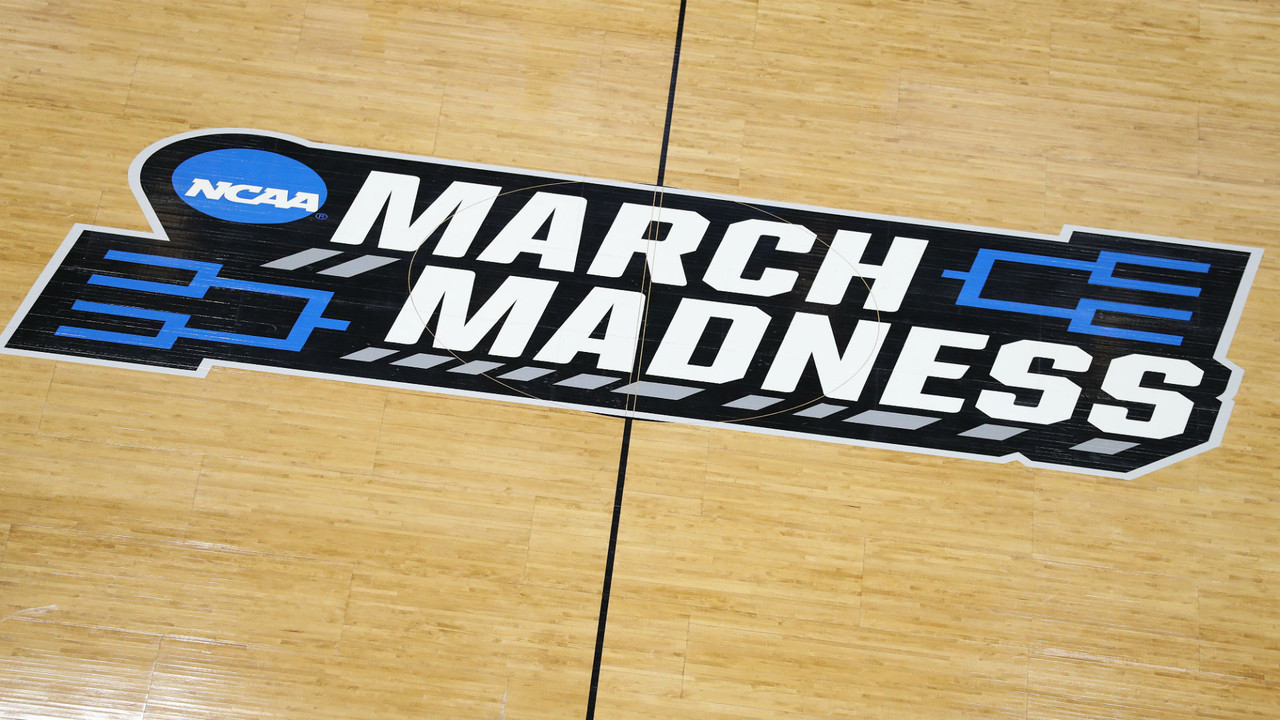

## Problem Statement: What are the key performance metrics that determines a team's success in this tournament? Can we use these metrics to build a model to make better predictions?

Dataset from Kaggle : **"March Madness Data"** by *Nishaan Amin*  
Source: https://www.kaggle.com/datasets/nishaanamin/march-madness-data (requires login)

---

### Essential Libraries

Let us begin by importing the essential Python Libraries.

> NumPy : Library for Numeric Computations in Python  
> Pandas : Library for Data Acquisition and Preparation  
> Matplotlib : Low-level library for Data Visualization  
> Seaborn : Higher-level library for Data Visualization  

In [138]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

# Import essential models and functions from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Import Decision Tree Classifier model from Scikit-Learn
from sklearn.tree import DecisionTreeClassifier

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint


import warnings
warnings.filterwarnings('ignore')

### Import the dataset

In [2]:
Tournament_data = pd.read_csv('2008-2022 Tournament Data.csv')
Tournament_data.head()

YEAR  SEED     TEAM  ROUND  KENPOM ADJUSTED EFFICIENCY  \
0  2022     1   Kansas      1                        25.5   
1  2022     1  Arizona     16                        27.2   
2  2022     1  Gonzaga     16                        33.0   
3  2022     1   Baylor     32                        26.3   
4  2022     2     Duke      4                        23.7   

   KENPOM ADJUSTED OFFENSE  KENPOM ADJUSTED DEFENSE  KENPOM ADJUSTED TEMPO  \
0                    119.4                     93.9                   69.1   
1                    119.6                     92.4                   72.2   
2                    121.8                     88.8                   72.5   
3                    117.9                     91.6                   67.2   
4                    119.4                     95.7                   67.4   

   BARTTORVIK ADJUSTED EFFICIENCY  BARTTORVIK ADJUSTED OFFENSE  ...  \
0                            27.2                        120.1  ...   
1                            25.6                        117.4  ...   
2                            31.8                        120.2  ...   
3                            26.3                        116.6  ...   
4                            25.8                        119.9  ...   

   OP ASSIST %  OP O REB %  OP D REB %  BLOCKED %  TURNOVER % DEFENSE  \
0         47.5        28.9        66.6        7.8                18.4   
1         46.8        28.3        65.5        7.0                17.7   
2         40.6        23.0        71.0        6.6                17.0   
3         55.5        28.4        63.7        7.3                22.9   
4         51.8        28.5        68.1        8.1                16.1   

   WINS ABOVE BUBBLE  WIN %  POINTS PER POSSESSION OFFENSE  \
0               10.4  82.35                          1.119   
1                8.8  91.18                          1.155   
2                6.7  89.66                          1.190   
3                8.9  81.25                          1.112   
4                7.2  82.35                          1.169   

   POINTS PER POSSESSION DEFENSE   TEAM.1  
0                          0.970   Kansas  
1                          0.922  Arizona  
2                          0.885  Gonzaga  
3                          0.925   Baylor  
4                          0.979     Duke  

[5 rows x 41 columns]

### Context
The data set imported above contains tournament and team stats from 2008-2022 (excluding 2020 due to COVID). Lets try build a model that can help us predict success in the tournament.

We determine success in the tournament as the teams that make it to the Elite 8 and hence we will use 'Round' as the response variable. 

It is important to note the context of our problem. If we were to pick from the 68 teams at random and succesfully select an elite 8 team, the odds would be 8/68 which would equate to roughly 12%. Lets see if we can do better than this 12% figure.

---
## Exploratory Data Analysis

Let us start by exploring the response variable `Round`, the one we are supposed to predict at the end of the day. 

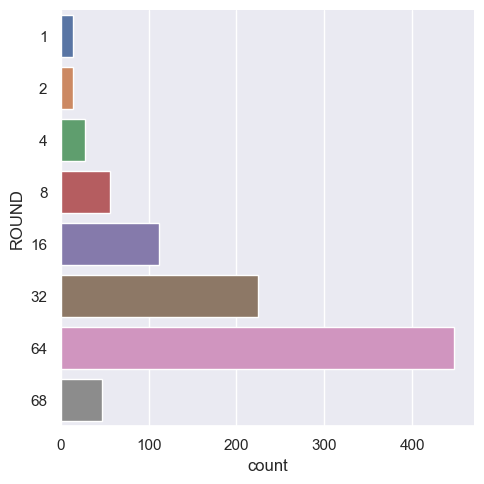

In [28]:
sb.catplot(y = 'ROUND', data = Tournament_data, kind = "count")

In [29]:
Tournament_data['ROUND'].dtypes

dtype('int64')

We can see that as each round progresses, the number of teams are halved. We also notice that 'Round' is a numerical variable. We have to change it to a categorical variable. 

### Cleaning the data: 
Lets first change 'Round' to a categorical type. Since we are only concerned with teams that make the top 8, lets narrow down the categories of rounds to just "Elite 8" and "Not Elite 8"

In [169]:
# Creating a dataframe for the response variable
Round = pd.DataFrame(Tournament_data['ROUND'])

# Convert round dtype from int 64 to object (categorical)
Round = Round.astype('object')

# create a dictionary to map the Round values to their new names
round_names = {8: 'Elite 8', 4: 'Elite 8', 2: 'Elite 8', 1: 'Elite 8', 68: 'Not Elite 8', 64: 'Not Elite 8', 32: 'Not Elite 8', 16: 'Not Elite 8'}

# Renaming the rows to reduce the number of categories
Round = Round.replace(round_names)

Now that we know our response variable, its time to find suitable predictor variables. As a starting point, we plugged in close to 20 variables as predictor features.

Response Variable : **Round**     
Predictor Feature : **BARTTORVIK ADJUSTED EFFICIENCY**, **BARTTORVIK ADJUSTED OFFENSE**, **BARTTORVIK ADJUSTED DEFENSE**, **BARTTORVIK ADJUSTED TEMPO**, **WIN%**, **2PT%**, **3PT%**, **FREE THROW %**, **3PT RATE**, **ASSIST%**, **OFFENSIVE REBOUND%**, **DEFENSIVE REBOUND%**, **BLOCK%**, **TURNOVER%**, **POINTS PER POSSESSION OFFENSE**, **POINTS PER POSSESSION DEFENSE**     

Extract the variables and the associated data as a Pandas `DataFrame`.

In [112]:
Metrics = pd.DataFrame(Tournament_data[['BARTTORVIK ADJUSTED EFFICIENCY','BARTTORVIK ADJUSTED OFFENSE','BARTTORVIK ADJUSTED DEFENSE','BARTTORVIK ADJUSTED TEMPO','WIN %','2PT %','3PT %','FREE THROW %','EFG %','FREE THROW RATE','3PT RATE','ASSIST %','OFFENSIVE REBOUND %','DEFENSIVE REBOUND %','BLOCK %','TURNOVER %','POINTS PER POSSESSION OFFENSE','POINTS PER POSSESSION DEFENSE']])

In [113]:
Metrics.describe()

BARTTORVIK ADJUSTED EFFICIENCY  BARTTORVIK ADJUSTED OFFENSE  \
count                      943.000000                   943.000000   
mean                        14.779003                   110.444115   
std                          9.304236                     6.313994   
min                        -16.200000                    89.200000   
25%                          9.650000                   106.500000   
50%                         16.400000                   110.500000   
75%                         21.250000                   114.750000   
max                         36.200000                   127.500000   

       BARTTORVIK ADJUSTED DEFENSE  BARTTORVIK ADJUSTED TEMPO       WIN %  \
count                   943.000000                 943.000000  943.000000   
mean                     95.665111                  67.553446   72.545270   
std                       5.231292                   3.116156    9.958894   
min                      81.600000                  57.800000   36.670000   
25%                      92.200000                  65.500000   65.630000   
50%                      95.200000                  67.400000   72.730000   
75%                      99.000000                  69.600000   78.790000   
max                     114.700000                  77.200000  100.000000   

            2PT %       3PT %  FREE THROW %       EFG %  FREE THROW RATE  \
count  943.000000  943.000000    943.000000  943.000000       943.000000   
mean    51.026193   35.882927     71.122481   51.999152        36.957052   
std      2.989526    2.666043      3.643116    2.730274         5.537745   
min     41.500000   26.500000     59.600000   41.900000        22.000000   
25%     49.100000   34.000000     68.600000   50.000000        33.000000   
50%     50.900000   35.900000     71.100000   52.000000        37.000000   
75%     52.800000   37.700000     73.700000   53.900000        40.450000   
max     64.000000   44.200000     82.600000   61.000000        55.900000   

         3PT RATE    ASSIST %  OFFENSIVE REBOUND %  DEFENSIVE REBOUND %  \
count  943.000000  943.000000           943.000000           943.000000   
mean    34.678897   54.589926            32.597561            70.524390   
std      5.280663    5.216041             4.275261             3.209259   
min     20.600000   37.900000            17.800000            60.700000   
25%     31.200000   51.100000            29.650000            68.350000   
50%     34.600000   54.300000            32.600000            70.400000   
75%     38.200000   58.100000            35.400000            72.700000   
max     53.500000   72.000000            45.300000            81.400000   

          BLOCK %  TURNOVER %  POINTS PER POSSESSION OFFENSE  \
count  943.000000  943.000000                     943.000000   
mean    10.565536   18.093425                       1.087409   
std      2.909901    2.079640                       0.049885   
min      3.700000   12.400000                       0.907000   
25%      8.500000   16.700000                       1.054000   
50%     10.300000   17.900000                       1.087000   
75%     12.500000   19.400000                       1.122500   
max     21.400000   24.700000                       1.241000   

       POINTS PER POSSESSION DEFENSE  
count                     943.000000  
mean                        0.972245  
std                         0.044878  
min                         0.834000  
25%                         0.942000  
50%                         0.974000  
75%                         1.003000  
max                         1.119000

We have looked at the distribution of our predictor variable. Now let us visualize the distributions of the predictor variables.

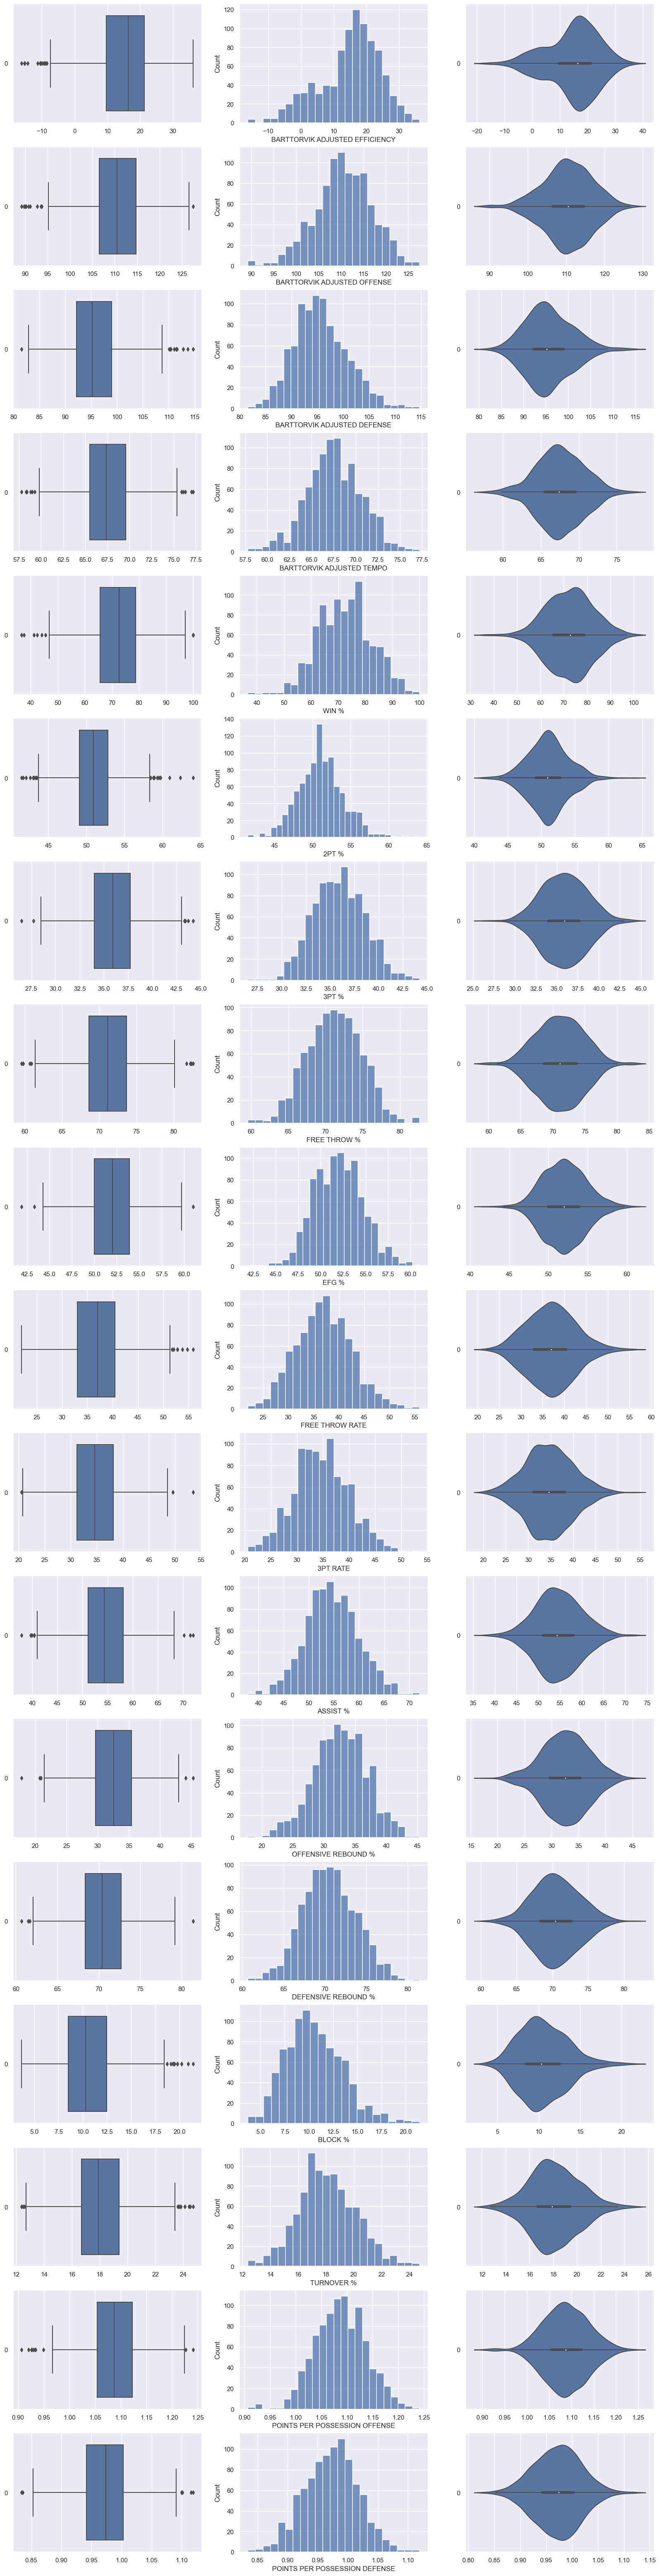

In [114]:
# Draw the distributions of all Predictors
f, axes = plt.subplots(18, 3, figsize=(20, 80))

count = 0
for var in Metrics:
    sb.boxplot(data = Metrics[var], orient = "h", ax = axes[count,0])
    sb.histplot(data = Metrics[var], ax = axes[count,1])
    sb.violinplot(data = Metrics[var], orient = "h", ax = axes[count,2])
    count += 1
    

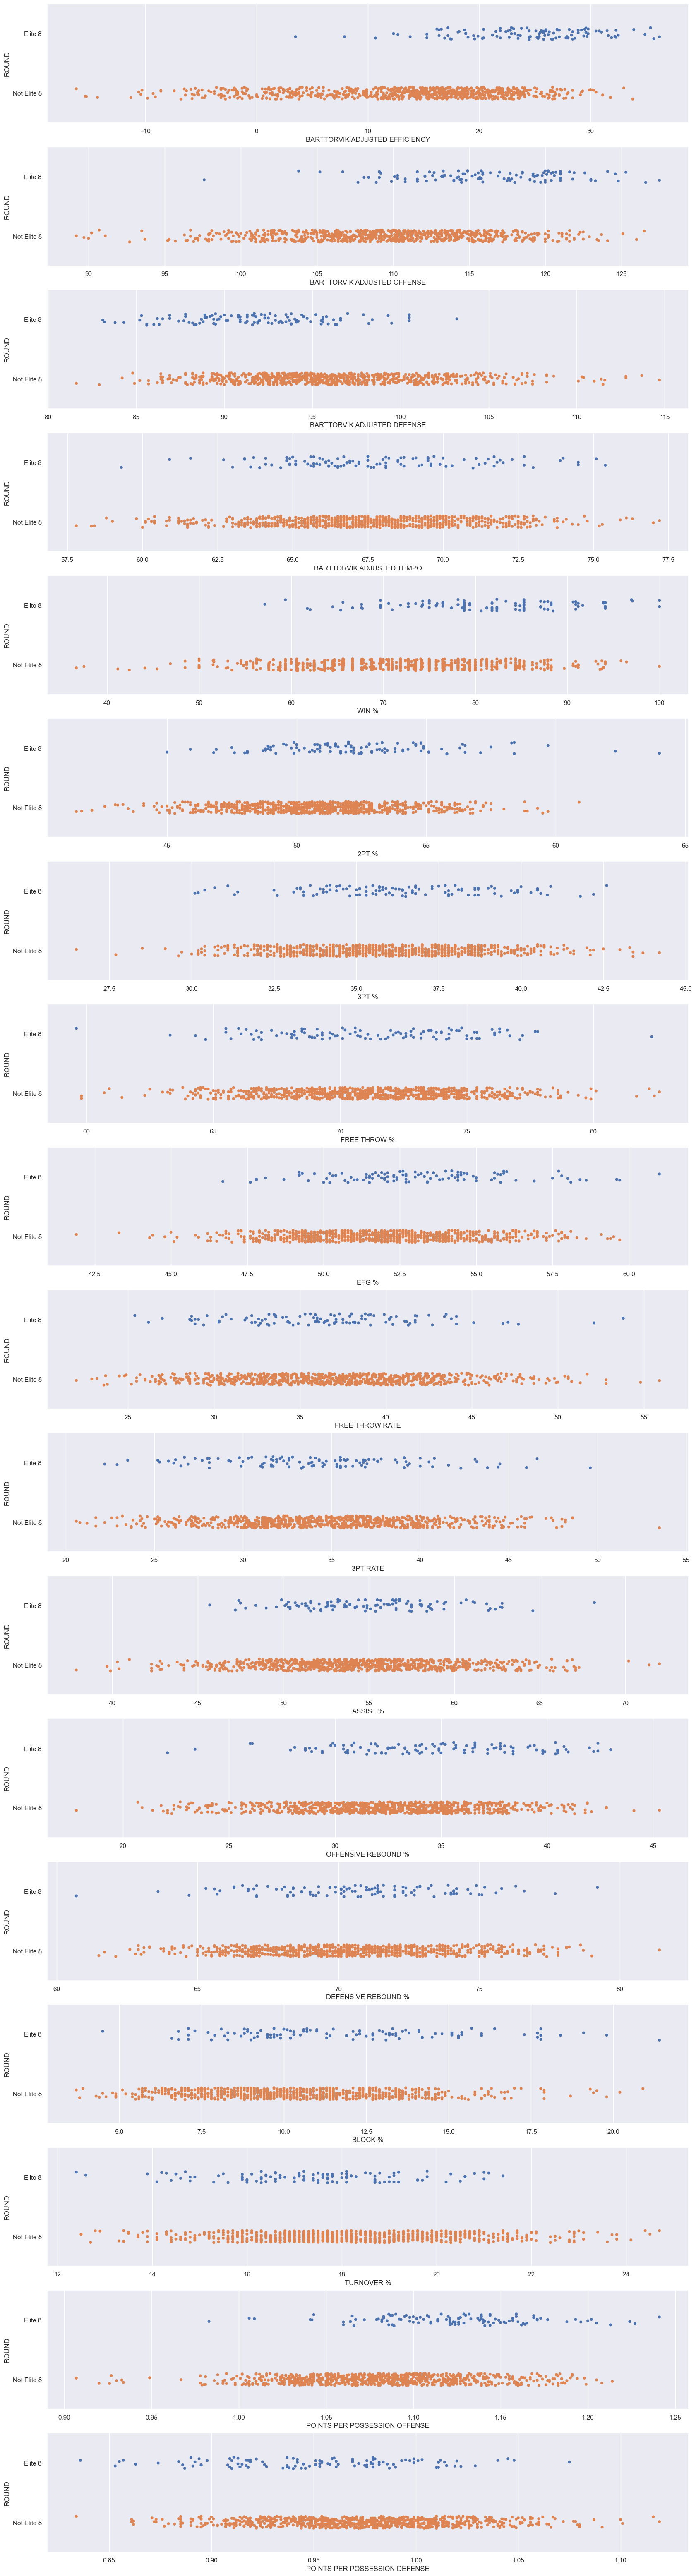

In [115]:
# Relationship between Response and the Predictors
togetherDF = pd.concat([Round, Metrics], axis = 1).reindex(Round.index)

f, axes = plt.subplots(18, 1, figsize=(20, 80))

count = 0
for var in Metrics:
    sb.stripplot(x = var, y = "ROUND", data = togetherDF, orient = "h", ax = axes[count])
    count += 1

# Machine Learning

## First we explored a new model learnt out of course: Poisson model. 
It is commonly used to model count data and predict events in a given time frame or space. Although it may not be the most obvious choice for predicting the success of basketball teams in the March Madness tournament, there are a few reasons why we considered it for our project:

1) Discrete outcomes: The Poisson model can be used to predict the number of times a team reaches a certain stage in the tournament, which can be treated as discrete count data. Since our problem statement revolves around identifying key performance metrics that determine a team's success in the tournament, the Poisson model can help us understand how these metrics contribute to a team's frequency of reaching the top 8, for example.

2) Comparing metrics: By fitting a Poisson model to our data, we can compare the coefficients and p-values of different performance metrics (e.g., Adjusted Efficiency, Offence, Defence, and Tempo) to determine which factors have a more significant impact on a team's success. This information can then be used to inform our model selection process and refine our predictions.

3) Exploration of alternatives: It's essential to explore different modeling techniques in any data science project to find the best possible model for the task at hand. Considering the Poisson model allows us to assess its performance relative to other models.


In [101]:
import statsmodels.api as sm
rou= Tournament_data[['ROUND']]
rou['rounds_won'] = rou['ROUND']
def calculate_rounds_won(round):
    if round == 1:
        return 6    # first place = 6 rounds won#
    elif round == 2:
        return 5    # top 2 = 5 rounds won#
    elif round == 4:
        return 4    #top 4 = 4 rounds won#
    elif round == 8:
        return 3     #top 8 = 3 rounds won#
    elif round == 16:
        return 2     #top 16 = 2rounds won#
    elif round == 32:
        return 1  #top 32 = 1 round won#
    else:         #top 64/68 = 0 rounds won#
        return 0
rou.loc[:,'rounds_won'] = rou['ROUND'].apply(calculate_rounds_won)
#Convert ROUND to rounds_won such that it becomes count data to be used in Poisson

Round = rou[['rounds_won']]

Round.describe()

rounds_won
count  943.000000
mean     0.935313
std      1.324702
min      0.000000
25%      0.000000
50%      0.000000
75%      1.000000
max      6.000000

In [102]:
# Splitting in train and test set
MetricsPOI_train, MetricsPOI_test, RoundPOI_train, RoundPOI_test = train_test_split(Metrics, Round, test_size=0.2, random_state=0)

# Fit Poisson regression model
poisson_model = sm.GLM(RoundPOI_train, MetricsPOI_train, family=sm.families.Poisson()).fit()

# Make predictions on test set
RoundPOI_pred = poisson_model.predict(MetricsPOI_test)

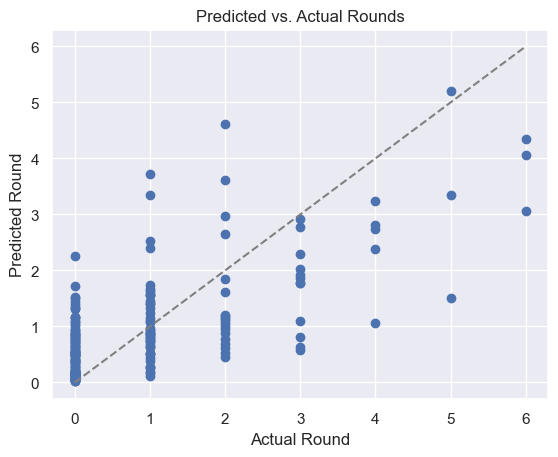

In [103]:
plt.scatter(RoundPOI_test, RoundPOI_pred)
plt.plot([0, 6], [0, 6], '--', color='gray')
plt.xlabel('Actual Round')
plt.ylabel('Predicted Round')
plt.title('Predicted vs. Actual Rounds')
plt.show()

In [36]:
print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             rounds_won   No. Observations:                  754
Model:                            GLM   Df Residuals:                      737
Model Family:                 Poisson   Df Model:                           16
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -825.67
Date:                Thu, 06 Apr 2023   Deviance:                       765.00
Time:                        00:35:57   Pearson chi2:                     880.
No. Iterations:                     9   Pseudo R-squ. (CS):             0.5094
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
BARTTORVIK A

The p-value is one of the indicators used to determine the significance of a predictor variable in a regression model. In general, a predictor with a lower p-value (below 0.05) is considered to be statistically significant and has a stronger association with the response variable. 

Based on the coefficients and their P-values, the predictors that are the best in predicting rounds_won are:

BARTTORVIK ADJUSTED EFFICIENCY (coef=0.0836, P<0.001)

WIN % (coef=0.0375, P<0.001)

3PT % (coef=-0.1838, P=0.044)

FREE THROW RATE (coef=-0.0274, P=0.018)

DEFENSIVE REBOUND % (coef=-0.0243, P=0.038)

POINTS PER POSSESSION DEFENSE (coef=6.5423, P=0.016)


### Limitations to the Poisson model:
1. overdispersion (assumption that variance of response variable = mean)
2. non-linear relationships (assumption that predictor and response variables are linear)
3. missing variables (assumption that we have all relevant variables in the model) 
4. outliers (assumption that data follows Poisson distribution).

In order to try and improve the model, we should address these limitations. Unfortunately, in the case of overdispersion and non-linear relationships, the best solution is to use another model. For outliers, we decided it was not ideal to cut out data since the outliers are likely going to be the higher round wins. 

### Conclusion: Therefore, due to these limitations, we deemed that the Poisson model was not very suitable. However, it was still useful in telling us which variables would be the more important factors in determining a team’s success. With this information, we could use the variables identified here and use it in other models.


Perhaps lets go back to a model that we have learnt previously in this course: 

# Multi-Variate Classification Tree

## Here are some reasons why we chose to use a Classification Tree for our March Madness prediction problem:

Interpretability: Classification Trees are easy to understand and visualize, making them highly interpretable. This is important in a sports context like March Madness, where explaining the model's predictions to non-technical stakeholders (e.g., coaches, team managers, or fans) is valuable.

Handling non-linear relationships: Classification Trees can capture non-linear relationships between predictor variables and the response variable, which can be beneficial in a complex scenario like predicting the success of basketball teams in the tournament.

Feature importance: Classification Trees can provide insights into the importance of different predictor variables. The higher a variable appears in the tree structure (closer to the root), the more important it is for making predictions. This can help us identify the key performance metrics that determine a team's success in the tournament.

Minimal data preprocessing: Classification Trees do not require extensive data preprocessing, such as normalization or scaling of predictor variables. This can simplify the modeling process and save time during the analysis.

Robustness to outliers: Classification Trees are relatively robust to the presence of outliers in the data, as they use binary splits to separate the data, which can be less sensitive to extreme values than other methods like linear regression.

From what we learnt from the Poisson model, we identified 6 variables that were more significant factors in determining a team's success. Lets make use of it as our predictor variables now and cut out the rest.

Let us set up the Multi-Variate Classification problem.   

Response Variable : **Round**     
Predictor Features : 

**BARTTORVIK ADJUSTED EFFICIENCY**

**WIN %**
                    
**3PT %**
                    
**FREE THROW RATE**
                    
**DEFENSIVE REBOUND %**
                    
**POINTS PER POSSESION DEFENSE**                 

In [231]:
# Creating a new dataframe with the identified predictor variables
Metrics_2 = pd.DataFrame(Tournament_data[['BARTTORVIK ADJUSTED EFFICIENCY','WIN %','3PT %','FREE THROW RATE','DEFENSIVE REBOUND %','POINTS PER POSSESSION DEFENSE']])

Set up the classification problem with Train and Test datasets.   
Train:Test in 80:20 split

In [213]:
# Split the Dataset into Train and Test
MetricsCT_train, MetricsCT_test, RoundCT_train, RoundCT_test = train_test_split(Metrics_2, Round, test_size = 0.20, random_state = 65)

# Check the sample sizes
print("Train Set :", MetricsCT_train.shape, RoundCT_train.shape)
print("Test Set  :", MetricsCT_test.shape, RoundCT_test.shape)

Train Set : (754, 6) (754, 1)
Test Set  : (189, 6) (189, 1)


In [214]:
#### Import DecisionTreeClassifier model from Scikit-Learn
from sklearn.tree import DecisionTreeClassifier

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)  # create the decision tree object
dectree.fit(MetricsCT_train, RoundCT_train)                    # train the decision tree model

DecisionTreeClassifier(max_depth=4)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.916445623342175

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.8994708994708994



<AxesSubplot:>

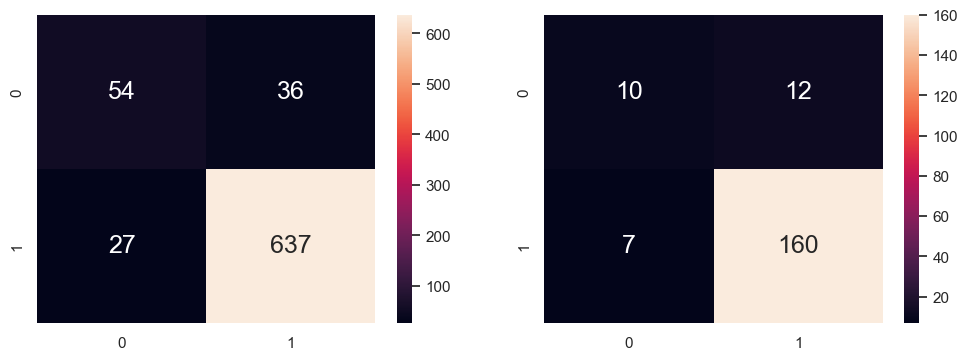

In [215]:
from sklearn.metrics import confusion_matrix

# Predict Response corresponding to Predictors
RoundCT_train_pred = dectree.predict(MetricsCT_train)
RoundCT_test_pred = dectree.predict(MetricsCT_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(MetricsCT_train, RoundCT_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(MetricsCT_test, RoundCT_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(RoundCT_train, RoundCT_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(RoundCT_test, RoundCT_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])


In [216]:
print(Round.value_counts())

ROUND      
Not Elite 8    831
Elite 8        112
dtype: int64


In [217]:
# Plot the trained Decision Tree
from sklearn.tree import plot_tree

f = plt.figure(figsize=(150,100))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=MetricsCT_train.columns, 
          class_names=["Elite 8","Not Elite 8"])

[Text(0.5089285714285714, 0.9, 'BARTTORVIK ADJUSTED EFFICIENCY <= 24.45\ngini = 0.21\nsamples = 754\nvalue = [90, 664]\nclass = Not Elite 8'),
 Text(0.2857142857142857, 0.7, 'BARTTORVIK ADJUSTED EFFICIENCY <= 16.15\ngini = 0.114\nsamples = 657\nvalue = [40, 617]\nclass = Not Elite 8'),
 Text(0.14285714285714285, 0.5, 'POINTS PER POSSESSION DEFENSE <= 1.044\ngini = 0.032\nsamples = 370\nvalue = [6, 364]\nclass = Not Elite 8'),
 Text(0.07142857142857142, 0.3, 'DEFENSIVE REBOUND % <= 63.65\ngini = 0.017\nsamples = 340\nvalue = [3, 337]\nclass = Not Elite 8'),
 Text(0.03571428571428571, 0.1, 'gini = 0.245\nsamples = 7\nvalue = [1, 6]\nclass = Not Elite 8'),
 Text(0.10714285714285714, 0.1, 'gini = 0.012\nsamples = 333\nvalue = [2, 331]\nclass = Not Elite 8'),
 Text(0.21428571428571427, 0.3, 'BARTTORVIK ADJUSTED EFFICIENCY <= 9.95\ngini = 0.18\nsamples = 30\nvalue = [3, 27]\nclass = Not Elite 8'),
 Text(0.17857142857142858, 0.1, 'gini = 0.0\nsamples = 24\nvalue = [0, 24]\nclass = Not Elite 8

### From the confusion matrix, the top row is what we are concerned with. We can see that for the training set, 54/90 were true in predicting the top 8 and in the test set 10/22 were true. From the random odds at the start of (12%) to 60% accuracy in the train set and 45% accuracy in the test set. There is improvement using this model. 

## Any limitations? 
Some limitations include tendency to overfit the data, which can be mitigated by using techniques like pruning or employing ensemble methods like Random Forests. Thus we decided to also try using a Random Forest model to potentially address these limitations. 

# Random Forest Classification model

Random Forest is a supervised learning algorithm that uses ensemble learning method for classification. Ensemble learning method is a technique that combines predictions from multiple machine learning algorithms to make a more accurate prediction than a single model.

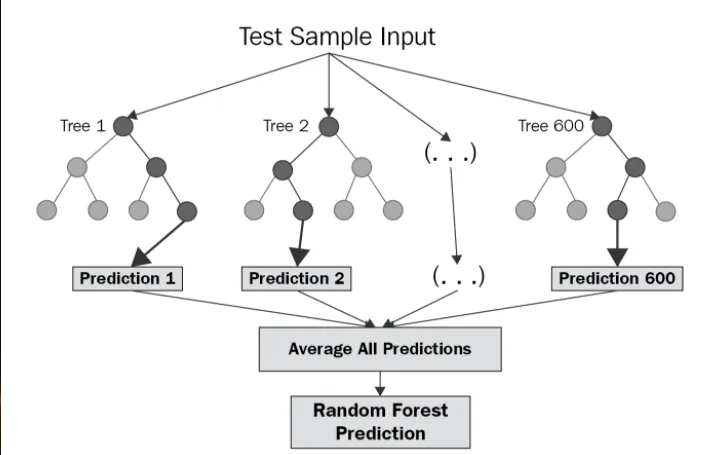

The diagram above shows the structure of a Random Forest. You can notice that the trees run in parallel with no interaction amongst them. A Random Forest operates by constructing several decision trees during training time and outputting the mean of the classes as the prediction of all the trees.

### Identifying the x and y variables

We will use the same predictor and response variables as in the classification model previously. 
Response Variable : **Round**     
Predictor Feature :

**BARTTORVIK ADJUSTED EFFICIENCY**

**WIN %**
                    
**3PT %**
                    
**FREE THROW RATE**
                    
**DEFENSIVE REBOUND %**
                    
**POINTS PER POSSESION DEFENSE**  

### Splitting the data into train and test set

In [218]:
# Split the Dataset into Train and Test
MetricsRF_train, MetricsRF_test, RoundRF_train, RoundRF_test = train_test_split(Metrics_2, Round, test_size = 0.20, random_state = 65)

# Check the sample sizes
print("Train Set :", MetricsRF_train.shape, RoundRF_train.shape)
print("Test Set  :", MetricsRF_test.shape, RoundRF_test.shape)

Train Set : (754, 6) (754, 1)
Test Set  : (189, 6) (189, 1)


### Training the Random Forest model on the whole dataset

In [232]:
# import Random Forest Regressor
from sklearn.ensemble import RandomForestClassifier 

# instantiate the regressor
classifier = RandomForestClassifier()

# fit the model
classifier.fit(MetricsRF_train, RoundRF_train)

RandomForestClassifier()

### Predicting the test set results

The simplest way to evaluate this model is using accuracy; we check the predictions against the actual values in the test set and count up how many the model got right.

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.8783068783068783



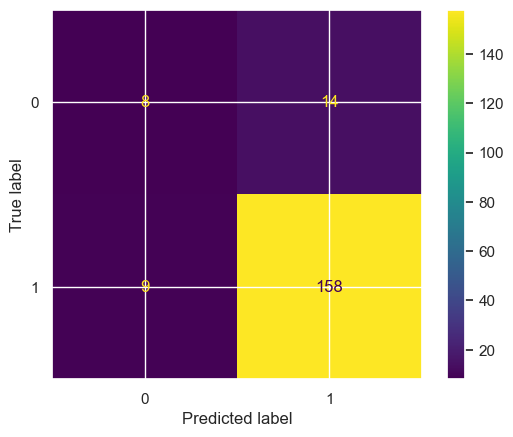

In [233]:
# Predict Response corresponding to Predictors
RoundRF_test_pred = classifier.predict(MetricsRF_test)

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", classifier.score(MetricsRF_test, RoundRF_test))
print()

# Plot the Confusion Matrix for Test
cm = confusion_matrix(RoundRF_test, RoundRF_test_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

### Random Forest Model: Slightly worse than classification tree
Similar to the classification tree, from the confusion matrix, the top row is what we are concerned with. We can see that in the test set, 8/22 were predicted to reach the top 8 and actually did. That is an accuracy of around 36% on the test data. This is higher than the original 12% figure we started with but it is lower than the accuracy score we got from the classification tree (45%).

### Conclusion: From the 3 models we tried out, we deemed that the Multi-Variate Classification Tree model was slightly better than the Random Forest Model based on their accuracy scores while the Poisson model was deemed the worst of the 3 due to its limitations.

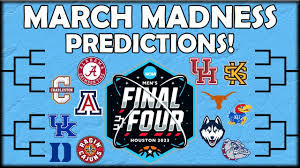

# Now the fun part! Lets use the model we identified as the best: classification tree model; to help predict the Elite 8 for this year's tournament.

In [207]:
# Extracting 2023 data
Tournament_data_2023 = pd.read_csv('2023 Tournament Data.csv')
Tournament_data_2023.head()

YEAR  SEED     TEAM  TEAM ROUND  CURRENT ROUND  KENPOM ADJUSTED EFFICIENCY  \
0  2023     1  Alabama           0              0                     26.9363   
1  2023     1  Houston           0              0                     29.8743   
2  2023     1   Kansas           0              0                     23.1345   
3  2023     1   Purdue           0              0                     24.7732   
4  2023     2  Arizona           0              0                     22.8757   

   KENPOM ADJUSTED OFFENSE  KENPOM ADJUSTED DEFENSE  KENPOM ADJUSTED TEMPO  \
0                  115.832                  88.8960                72.7700   
1                  118.854                  88.9798                63.3827   
2                  114.703                  91.5684                69.2256   
3                  119.951                  95.1774                64.2174   
4                  120.078                  97.2023                72.2672   

   BARTTORVIK ADJUSTED EFFICIENCY  ...  OP ASSIST %  OP O REB %  OP D REB %  \
0                          27.588  ...         41.8        27.6        66.2   
1                          28.290  ...         53.6        27.4        62.9   
2                          21.359  ...         46.2        28.3        71.6   
3                          25.247  ...         51.5        23.3        61.7   
4                          23.914  ...         49.4        26.2        68.9   

   BLOCKED %  TURNOVER % DEFENSE  WINS ABOVE BUBBLE      WIN %  \
0       11.4                16.0               10.6  85.294118   
1        6.6                22.0                8.4  91.176471   
2        7.3                20.2               10.5  79.411765   
3        8.6                15.4                9.2  85.294118   
4        9.3                16.9                7.5  82.352941   

   POINTS PER POSSESSION OFFENSE  POINTS PER POSSESSION DEFENSE   TEAM.1  
0                          1.106                          0.922  Alabama  
1                          1.158                          0.872  Houston  
2                          1.062                          0.963   Kansas  
3                          1.135                          0.974   Purdue  
4                          1.134                          0.981  Arizona  

[5 rows x 42 columns]

### This data is based on the stats throughout the team's regular season and naturally doesn't include the actual March Madness tournament stats. Hence why the columns for team round/current round are all 0.

In [208]:
# Extract teams for prediction
Team_data = pd.DataFrame(Tournament_data_2023[['TEAM']])
Team_data

TEAM
0                  Alabama
1                  Houston
2                   Kansas
3                   Purdue
4                  Arizona
..                     ...
63                  Howard
64       Northern Kentucky
65  Southeast Missouri St.
66  Texas A&M Corpus Chris
67          Texas Southern

[68 rows x 1 columns]

In [209]:
# Extract Predictors for prediction
Metrics_2023 = pd.DataFrame(Tournament_data_2023[['BARTTORVIK ADJUSTED EFFICIENCY','WIN %','3PT %','FREE THROW RATE','DEFENSIVE REBOUND %','POINTS PER POSSESSION DEFENSE']])

# Predict response corresponding to predictors
Team_pred = dectree.predict(Metrics_2023)
Team_pred

array(['Elite 8', 'Elite 8', 'Not Elite 8', 'Elite 8', 'Not Elite 8',
       'Not Elite 8', 'Not Elite 8', 'Elite 8', 'Not Elite 8', 'Elite 8',
       'Not Elite 8', 'Not Elite 8', 'Elite 8', 'Not Elite 8',
       'Not Elite 8', 'Not Elite 8', 'Not Elite 8', 'Not Elite 8',
       'Not Elite 8', 'Not Elite 8', 'Not Elite 8', 'Not Elite 8',
       'Not Elite 8', 'Not Elite 8', 'Not Elite 8', 'Elite 8',
       'Not Elite 8', 'Not Elite 8', 'Not Elite 8', 'Elite 8',
       'Not Elite 8', 'Not Elite 8', 'Not Elite 8', 'Not Elite 8',
       'Not Elite 8', 'Not Elite 8', 'Not Elite 8', 'Not Elite 8',
       'Not Elite 8', 'Not Elite 8', 'Not Elite 8', 'Not Elite 8',
       'Not Elite 8', 'Not Elite 8', 'Not Elite 8', 'Not Elite 8',
       'Not Elite 8', 'Not Elite 8', 'Not Elite 8', 'Not Elite 8',
       'Not Elite 8', 'Not Elite 8', 'Not Elite 8', 'Not Elite 8',
       'Not Elite 8', 'Not Elite 8', 'Not Elite 8', 'Not Elite 8',
       'Not Elite 8', 'Not Elite 8', 'Not Elite 8', 'Not Elite 8

### So which teams are predicted to make the Elite 8?

In [210]:
Team_pred = pd.DataFrame(Team_pred, columns = ["Prediction"], index = Team_data.index)
Team_data_pred = pd.concat([Tournament_data_2023[["TEAM"]], Team_pred], axis = 1)
Team_data_pred = Team_data_pred[Team_data_pred["Prediction"].isin(["Elite 8"])]
Team_data_pred

TEAM Prediction
0       Alabama    Elite 8
1       Houston    Elite 8
3        Purdue    Elite 8
7          UCLA    Elite 8
9       Gonzaga    Elite 8
12  Connecticut    Elite 8
25     Missouri    Elite 8
29         Iowa    Elite 8

# March Madness has ended. Lets check how our predictions did!

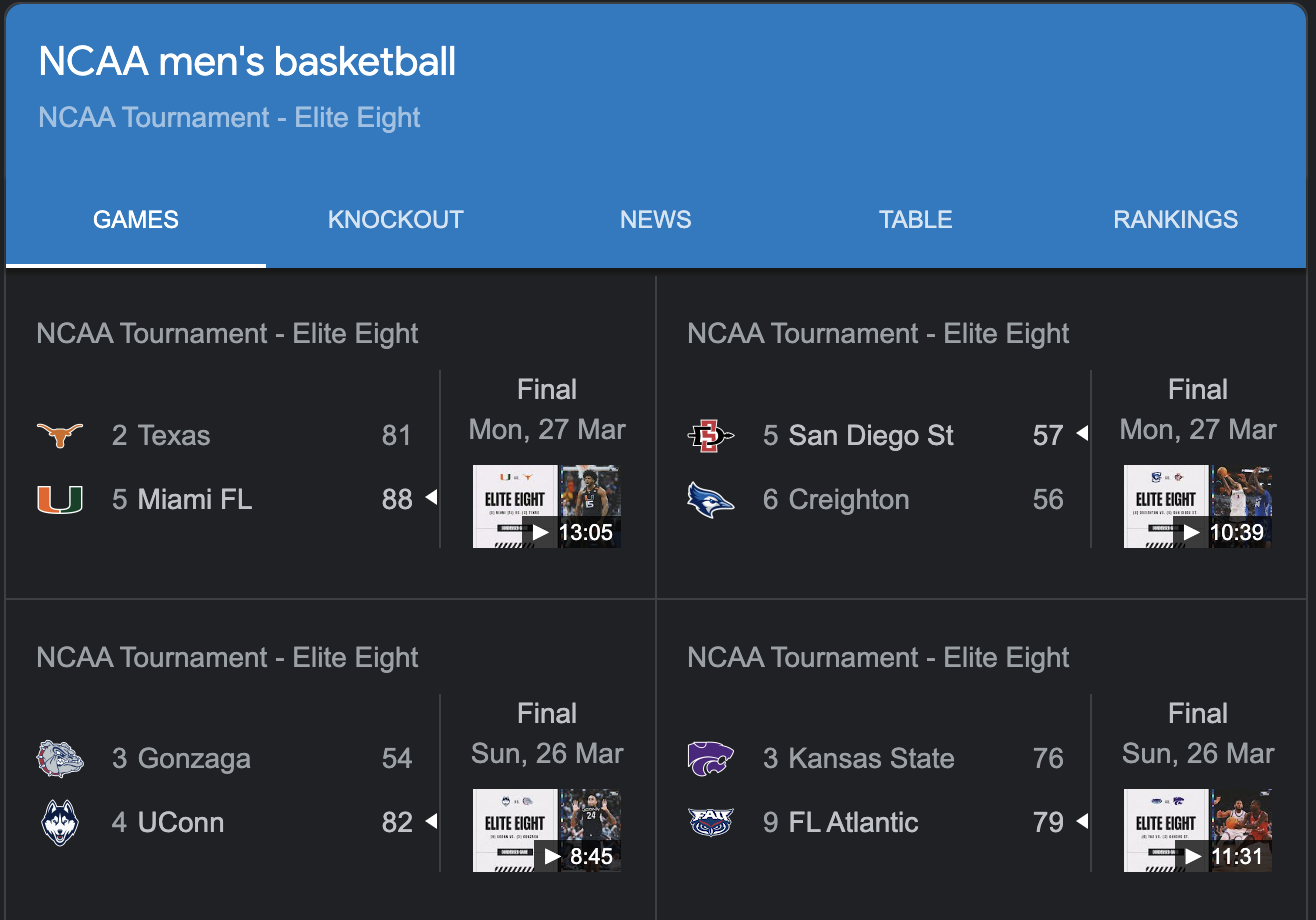

### From the classification model, only 1/8 of the teams predicted actually made it the the Elite 8: Gonzaga. 

## We were of course hoping for a better accuracy but we recognise that there are external factors that would affect the accuracy.

Changes in patterns: The factors that determined the success of teams in previous years might have changed in 2023. For instance, there could be new strategies, coaching staff, or rules that impact the performance of teams. In such cases, the model trained on historical data might not be able to capture these changes effectively.

Variability in sports: Sports outcomes can be inherently unpredictable due to various factors like injuries, form, and team dynamics. The variability in sports outcomes can make it challenging to develop a highly accurate predictive 

Small sample size: The Elite 8 is a small subset of the total teams in the tournament, which means that even a few incorrect predictions can significantly impact the accuracy score. 

### Final thoughts: Even a well-performing model might not be able to predict the outcomes of sports events perfectly due to their unpredictable nature. However, with careful model selection, feature engineering, and validation techniques, we can improve the predictive performance of your model on the latest data. Til next March, adios!